In [1]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
df = pd.read_csv('AAPL.csv')

In [2]:
df.set_index('Date', inplace=True)
df.head()

NameError: name 'df' is not defined

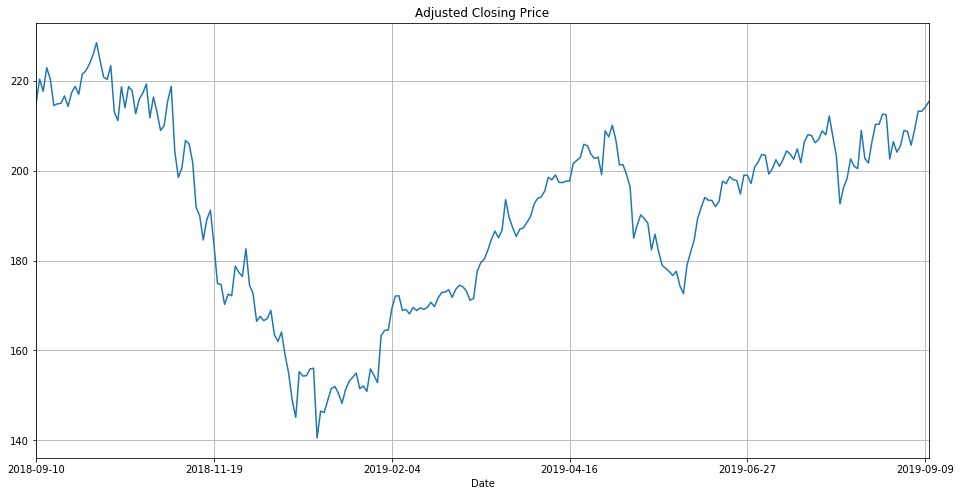

In [5]:
df['Adj Close'].plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [6]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [7]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [8]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [9]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

In [10]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

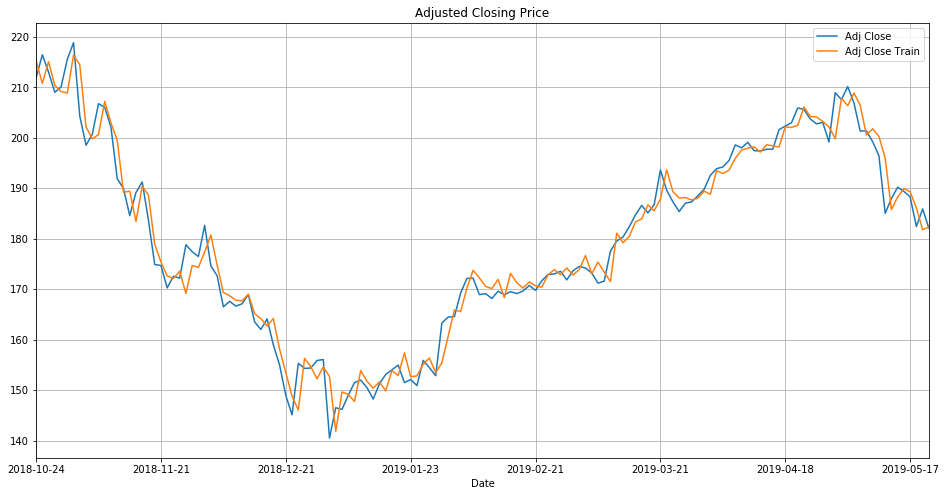

In [11]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

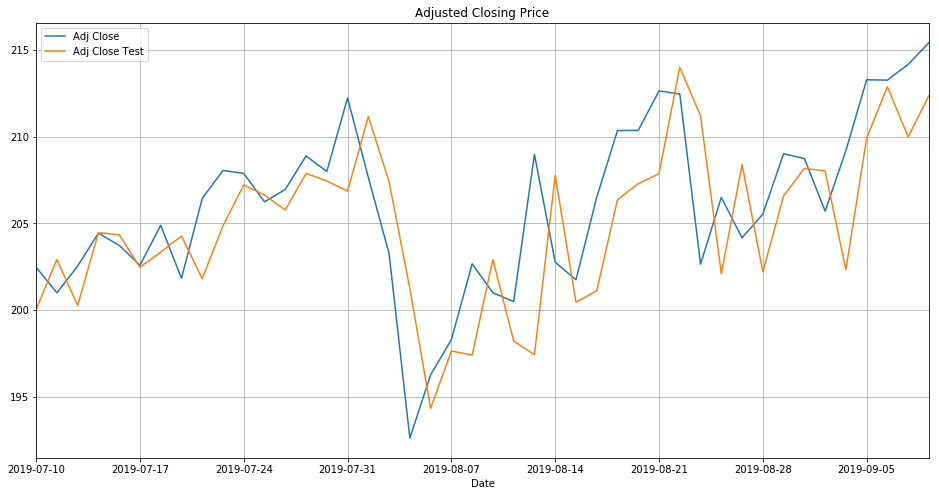

In [12]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [ ]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

In [ ]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [ ]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [ ]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

In [ ]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

In [ ]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

In [ ]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

In [ ]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [ ]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

In [ ]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

In [ ]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [ ]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [ ]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [ ]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='AAPL', figsize=(16,8), title='Adjusted Closing Price', grid=True)